# Wykorzystanie głebokich konwolucyjnych do klasyfikacji cech twarzy ze zbioru CelebA

<img src="https://pbs.twimg.com/media/Cxf17XAUAAAnGX9.jpg",width=800>
<img src="http://mmlab.ie.cuhk.edu.hk/projects/celeba/intro.png",width=800>

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Zaimportowanie bibliotek

In [3]:
#operacje związane ze ścieżkami
import os
from glob import glob

#operacje na macierzach
import numpy as np

#operacje na danych tabelarycznych
import pandas as pd

#operacje na obrazach
from PIL import Image

#miła dla oka wizualizacja postępu i nie tylko
from tqdm import tqdm

#tworzenie wykresów i wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

#funkcja ułatwiająca podział zbioru danych na treningowy i testowy
from sklearn.model_selection import train_test_split

#importy z biblioteki keras, umożlkiwiające krótszy zapis implementacji
from keras.layers import Dense, Input, Dropout
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
np.random.seed(1118) #ziarno do generacji liczb pseudolosowych - wybierz swoje, ale może wpłynąć na wyniki

## Stałe wykorzystywane w następnych krokach

In [3]:
dataset_dir = '../img_align_celeba'
model_dir = '../models'

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

labels_path = '../list_attr_celeba.txt'
landmarks_path = '../list_landmarks_align_celeba.txt'

## Wczytanie danych

### Etykiety dotyczące cech twarzy

In [4]:
attributes = []
with open(labels_path, 'r') as f:
    f.readline()
    attribute_names = ['fn']+f.readline().strip().split(' ')
    for i, line in enumerate(f):
        fields = line.strip().replace('  ', ' ').split(' ')
        img_name = fields[0]
        if int(img_name[:6]) != i + 1:
            raise ValueError('Parse error.')
        attr_vec = np.array([fields[0]]+[int(x) for x in fields[1:]])
        attributes.append(attr_vec)
attributes = np.array(attributes)

In [5]:
df = pd.DataFrame(data=attributes,columns=attribute_names)
df.head()

,fn,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


### Dostępne cechy

In [6]:
for feature in df.columns[1:]:
    print(feature)

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


### Badana cecha

In [7]:
examined_feature = 'Eyeglasses'

## Lokalizacje miejsc charakterystycznych

In [8]:
landmarks={}
with open(landmarks_path, "r") as f:
    lines = f.readlines()
    list_land = lines[1].rstrip().split()
    for celeb in lines[2:]:
        celeb = celeb.rstrip().split()
        img = celeb[0]
        landmarks[img] = {land:val for land,val in zip(list_land, celeb[1:])}

In [9]:
df_land = pd.DataFrame(landmarks).transpose().astype('int')
df_land.head()

,lefteye_x,lefteye_y,leftmouth_x,leftmouth_y,nose_x,nose_y,righteye_x,righteye_y,rightmouth_x,rightmouth_y
000001.jpg,69,109,73,152,77,142,106,113,108,154
000002.jpg,69,110,70,151,81,135,107,112,108,153
000003.jpg,76,112,74,156,108,128,104,106,98,158
000004.jpg,72,113,71,155,101,138,108,108,101,151
000005.jpg,66,114,71,147,86,119,112,112,104,150


## Interesują nas wpółrzędne będące centrum między oczami

In [10]:
df_eyes = pd.DataFrame()
df_eyes['x_mid'] = (df_land.lefteye_x + df_land.righteye_x)//2
df_eyes['y_mid'] = (df_land.lefteye_y + df_land.righteye_y)//2
df_eyes.head()

,x_mid,y_mid
000001.jpg,87,111
000002.jpg,88,111
000003.jpg,90,109
000004.jpg,90,110
000005.jpg,89,113


### Wykorzystamy losowo wybrane (maksymalnie) 10 000 obrazów

#### Zbalansowanie porządanej cechy

In [11]:
df_balanced = df.groupby(examined_feature)
n_samples = np.min([10000//2,df_balanced.size().min()])
n_samples

5000

In [12]:
df_balanced = (pd.DataFrame(df_balanced.apply(lambda x: x.sample(n_samples).reset_index(drop=True))).set_index('fn')[examined_feature]).to_frame()
df_balanced.head()

,Eyeglasses
fn,
160481.jpg,-1
031427.jpg,-1
008701.jpg,-1
168006.jpg,-1
083178.jpg,-1


In [13]:
print('Mamy',str(len(df_balanced)),'obrazów')

Mamy 10000 obrazów


### Left join

In [14]:
df_balanced = df_balanced.merge(df_eyes,how='left',left_index=True,right_index=True).reset_index()
df_balanced.head()

,fn,Eyeglasses,x_mid,y_mid
0,160481.jpg,-1,88,111
1,031427.jpg,-1,88,111
2,008701.jpg,-1,88,110
3,168006.jpg,-1,88,111
4,083178.jpg,-1,88,111


#### Wczytanie danych

* etykiet

In [15]:
labels = (df_balanced[examined_feature].values) == '1'

In [16]:
print(np.sum(labels==True),np.sum(labels==False))

5000 5000


* obrazów

Następnie poddamy je następującym zabiegom:
* Wycięcie obszarów o wielkości 48x96 w okolicy centrum oczu

Powyższe operacje wykonamy przy pomocy metod obiektu PIL.Image, co znacząco przyśpieszy proces i pozwili na zaoszczędzenie pamięci operacyjnej.

In [20]:
images = np.array(
    [np.array(Image.open(os.path.join(dataset_dir,x['fn'])).
              crop(box=(x['x_mid'] - 48,x['y_mid'] - 24,x['x_mid'] + 48,x['y_mid'] + 24)))
     for i,x in tqdm(df_balanced.iterrows())]).astype(np.uint8)

10000it [00:08, 1219.66it/s]


In [21]:
print('Wymiary macierzy obrazów to:',images.shape)

Wymiary macierzy obrazów to: (10000, 48, 96, 3)


## Wizualizacja danych

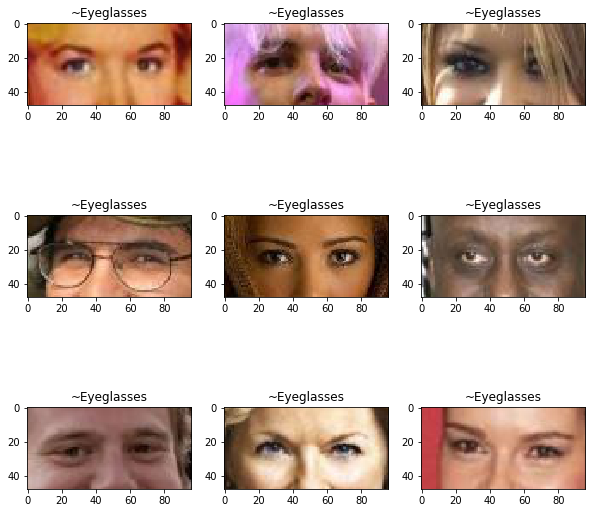

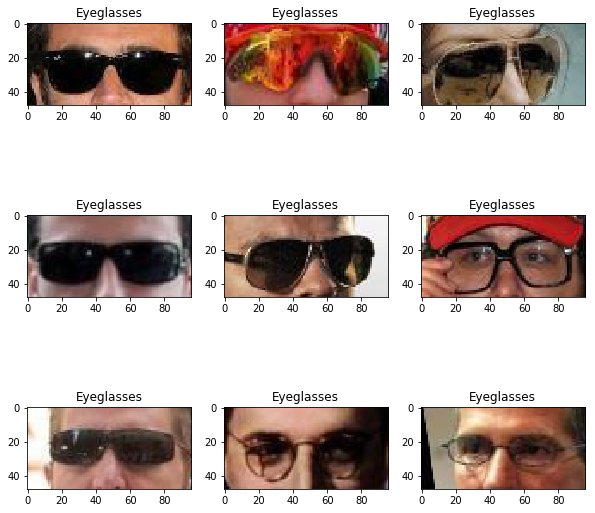

In [22]:
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[i]))
plt.show()
    
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.title(examined_feature if labels[len(labels) - i]==1 else '~'+examined_feature)
    plt.imshow(np.squeeze(images[len(labels) - i]))
plt.show()

## Podział danych na treningowe i testowe

In [50]:
X_train, X_test, y_train, y_test = train_test_split(images.astype('float32')/255, labels, test_size=0.2)

### Standaryzacja danych

In [51]:
X_mean = []
X_std = []
for i in range(3):
    X_mean.append(np.mean(X_train[:,:,:,i]))
    X_std.append(np.std(X_train[:,:,:,i]))
    
    X_train[:,:,:,i] = (X_train[:,:,:,i] - X_mean[-1])/X_std[-1]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - X_mean[-1])/X_std[-1]

## Stworzenie modelu

### Zdefiniowanie parametrów określających architekturę modelu

In [55]:
input_shape = images.shape[1:4] #wielkość obrazu wejściowego, wykorzystywana dla budowy grafu SN

### Zdefiniowanie parametrów definujących trening SN

In [56]:
batch_size = 32 #liczba obrazów wykorzystywana do jednego kroku treningu SN
optimizer = 'adam' #funkcja odpowiadająca za redukcję błędu sieci
loss_fn = 'binary_crossentropy' #funkcja służąca do obliczenia o ile różni się wartość oczekiwana od otrzymanej na wyjściu SN
epochs = 30 #maksymalna liczba epok, czyli ile razy sieć będzie widziała dane treningowe
model_path = os.path.join(model_dir,'celeb_cnn_v1.h5')

### Budowa architektury CNN

In [57]:
inputs = Input(shape=input_shape, name='input')

x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x, name='CNN')
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

### Wprowadzenie funkcji zwrotnych (ang. callback)

Umożliwią nam one dodatkową interakcję z modelem podczas treningu
* zatrzymanie trningu SN jeśli nie ma zauważalnej poprawy funkcji straty dla zbioru walidacyjnego po 3 epokach

In [58]:
early_stop = EarlyStopping(restore_best_weights = True, patience = 3)

* tworzenie punktów kontrolnych w postaci zapisanego modelu po każdej epoce

In [59]:
checkpt = ModelCheckpoint(model_path,save_best_only=True,save_weights_only=True)

### trening SN

In [60]:
history = model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, y_test),
                  verbose=2,
                  callbacks = [early_stop, checkpt])

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
 - 13s - loss: 0.1969 - acc: 0.9257 - val_loss: 0.0961 - val_acc: 0.9720
Epoch 2/30
 - 9s - loss: 0.0969 - acc: 0.9665 - val_loss: 0.0972 - val_acc: 0.9720
Epoch 3/30
 - 9s - loss: 0.0836 - acc: 0.9730 - val_loss: 0.0851 - val_acc: 0.9730
Epoch 4/30
 - 9s - loss: 0.0747 - acc: 0.9748 - val_loss: 0.0612 - val_acc: 0.9810
Epoch 5/30
 - 9s - loss: 0.0639 - acc: 0.9776 - val_loss: 0.0589 - val_acc: 0.9835
Epoch 6/30
 - 9s - loss: 0.0600 - acc: 0.9800 - val_loss: 0.0657 - val_acc: 0.9815
Epoch 7/30
 - 9s - loss: 0.0560 - acc: 0.9805 - val_loss: 0.0621 - val_acc: 0.9820
Epoch 8/30


KeyboardInterrupt: 

In [ ]:
model.load_weights(model_path)